In [19]:
import pandas as pd

df = pd.read_csv('../data/tweets.csv')
df = df[['text', 'target']]
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dyath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dyath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dyath\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\dyath\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [21]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
from nltk import pos_tag

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    tagged = pos_tag(tokens)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]

In [23]:
def cleen_tweet(tweet):
    # Minuscule
    tweet = tweet.lower()
    
    # Suppression des URLs, mentions, hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    tweet = re.sub(r"@\w+", '', tweet)
    tweet = re.sub(r"#", '', tweet)
    
    # Suppression ponctuation et chiffres
    tweet = re.sub(r"[^a-z\s]", '', tweet)
    
    # Tokenisation
    tokens = nltk.word_tokenize(tweet)
    
    # Filtrage : mots courts + stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and len(t) >= 3]
    
    # Lemmatisation
    tokens = lemmatize_tokens(tokens)
    
    return tokens

In [24]:
df['tokens'] = df['text'].apply(lambda x: cleen_tweet(x))

In [25]:
corpus = [
    token
    for tokens in df['tokens']
        for token in tokens
]

In [26]:
total_tokens = len(corpus)
unique_tokens = len(set(corpus))

print(f"Nombre total de tokens       : {total_tokens}")
print(f"Nombre de tokens uniques     : {unique_tokens}")

Nombre total de tokens       : 64069
Nombre de tokens uniques     : 12310


In [27]:
word_freq = Counter(corpus)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

C:\Users\dyath\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127781 (\N{WHITE SUN BEHIND CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


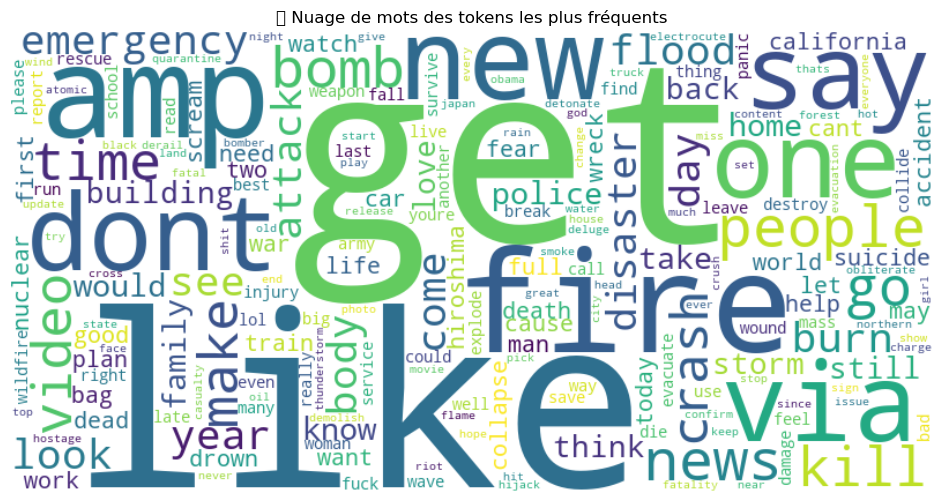

In [28]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("🌥️ Nuage de mots des tokens les plus fréquents")
plt.show()

In [29]:
df.to_csv('../data/cleaned_tweet.csv', index=False)

# Modeling

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
df.head()

,text,target,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [32]:
df['clean_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [33]:
X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(max_iter=1000))])

In [35]:
y_pred = pipeline.predict(X_test)

print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       869
           1       0.83      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



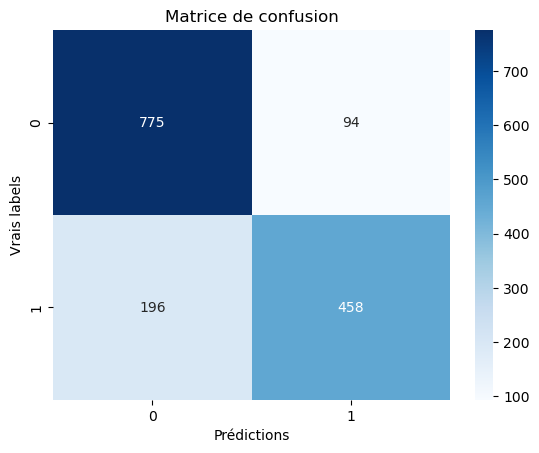

In [36]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Prédictions')
plt.ylabel('Vrais labels')
plt.title('Matrice de confusion')
plt.show()